In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from safetensors.torch import load_file
import torch

holdout_ft = load_file("../cached_tensors/holdout_esmfold_feats.st")["features"]

In [15]:
N, C = holdout_ft.shape
ft = holdout_ft[torch.randperm(N)]

In [20]:
from plaid.evaluation import calc_fid_fn, calc_kid_fn
from tqdm.notebook import tqdm, trange

fids = []
batch_size = 100
for i in trange(1, N // batch_size):
    fid = calc_fid_fn(ft[:batch_size], ft[i*batch_size:(i+1)*batch_size])
    fids.append(fid.item())

100%|██████████| 498/498 [02:15<00:00,  3.68it/s]


N=64

  0%|          | 0/778 [00:00<?, ?it/s]

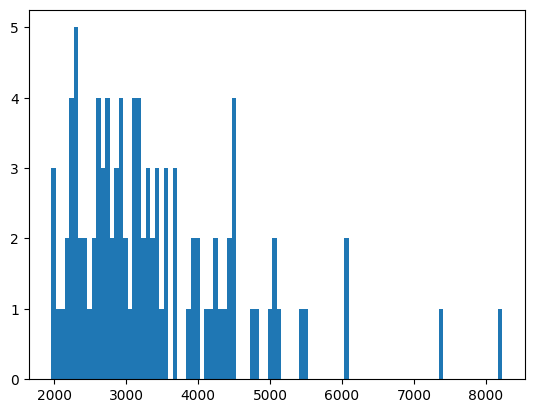

In [54]:
from plaid.evaluation import calc_fid_fn, calc_kid_fn
from tqdm.notebook import tqdm, trange

fids = []
batch_size = 64
for i in trange(1, N // batch_size):
    if i > 100:
        break
    fid = calc_fid_fn(ft[:batch_size], ft[i*batch_size:(i+1)*batch_size])
    fids.append(fid.item())
_ = plt.hist(fids, bins=100)

N=100

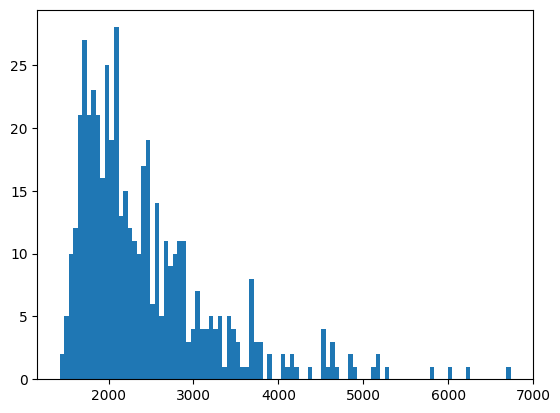

In [24]:
import matplotlib.pyplot as plt
_ = plt.hist(fids, bins=100)

N=500

  0%|          | 0/98 [00:00<?, ?it/s]

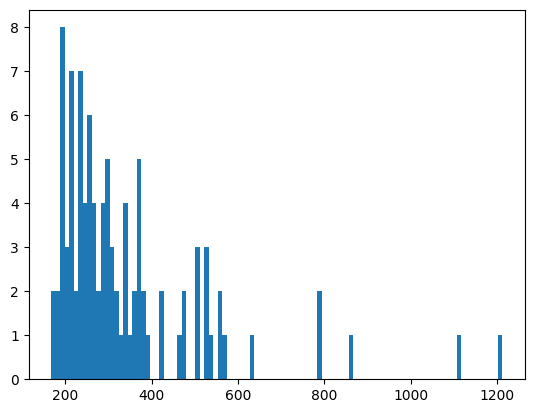

In [25]:
from plaid.evaluation import calc_fid_fn, calc_kid_fn
from tqdm.notebook import tqdm, trange

fids = []
batch_size = 500
for i in trange(1, N // batch_size):
    fid = calc_fid_fn(ft[:batch_size], ft[i*batch_size:(i+1)*batch_size])
    fids.append(fid.item())

_ = plt.hist(fids, bins=100)

N=1000

  0%|          | 0/48 [00:00<?, ?it/s]

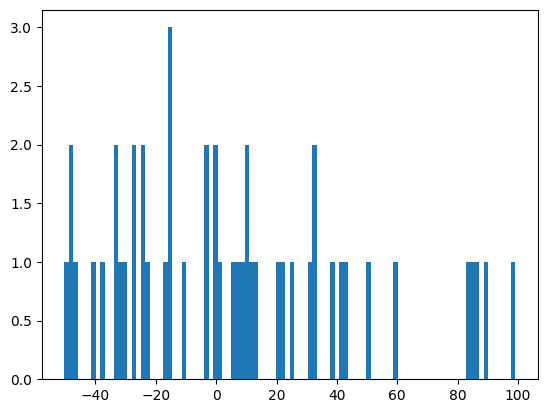

In [26]:
from plaid.evaluation import calc_fid_fn, calc_kid_fn
from tqdm.notebook import tqdm, trange

fids = []
batch_size = 1000
for i in trange(1, N // batch_size):
    fid = calc_fid_fn(ft[:batch_size], ft[i*batch_size:(i+1)*batch_size])
    fids.append(fid.item())

_ = plt.hist(fids, bins=100)

In [32]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
import numpy as np

def _npy(x):
    if isinstance(x, numpy.ndarray):
        return x
    elif isinstance(x, torch.Tensor):
        return x.numpy()
    else:
        return np.array(x)

def evodiff_calculate_fid(act1, act2):
    """calculate frechet inception distance"""
    # calculate mean and covariance statistics
    act1, act2 = _npy(act1), _npy(act2)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [41]:
"""
https://github.com/GaParmar/clean-fid/blob/main/cleanfid/fid.py

Numpy implementation of the Frechet Distance.
The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
and X_2 ~ N(mu_2, C_2) is
        d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
Stable version by Danica J. Sutherland.
Params:
    mu1   : Numpy array containing the activations of a layer of the
            inception net (like returned by the function 'get_predictions')
            for generated samples.
    mu2   : The sample mean over activations, precalculated on an
            representative data set.
    sigma1: The covariance matrix over activations for generated samples.
    sigma2: The covariance matrix over activations, precalculated on an
            representative data set.
"""
from scipy import linalg

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


"""
Compute the KID score given the sets of features
"""
def kernel_distance(feats1, feats2, num_subsets=100, max_subset_size=1000):
    n = feats1.shape[1]
    m = min(min(feats1.shape[0], feats2.shape[0]), max_subset_size)
    t = 0
    for _subset_idx in range(num_subsets):
        x = feats2[np.random.choice(feats2.shape[0], m, replace=False)]
        y = feats1[np.random.choice(feats1.shape[0], m, replace=False)]
        a = (x @ x.T / n + 1) ** 3 + (y @ y.T / n + 1) ** 3
        b = (x @ y.T / n + 1) ** 3
        t += (a.sum() - np.diag(a).sum()) / (m - 1) - b.sum() * 2 / m
    kid = t / num_subsets / m
    return float(kid)

def fid_from_feats(feats1, feats2):
    mu1, sig1 = np.mean(feats1, axis=0), np.cov(feats1, rowvar=False)
    mu2, sig2 = np.mean(feats2, axis=0), np.cov(feats2, rowvar=False)
    return frechet_distance(mu1, sig1, mu2, sig2)


# CleanFID Implementation

In [51]:
fid_from_feats(_npy(ft[:500]), _npy(ft[500:1000]))

884.8270044551828

In [47]:
kernel_distance(_npy(ft[:100]), _npy(ft[200:300]))

120738279.53750391

In [52]:
calc_fid_fn(ft[:500], ft[500:1000])

tensor(558.2892)

N=500

In [33]:
batch_size = 500
for i in trange(1, N // batch_size):
    fid = evodiff_calculate_fid(ft[:batch_size], ft[i*batch_size:(i+1)*batch_size])
    fids.append(fid.item())

  0%|          | 0/98 [00:00<?, ?it/s]